In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size'] = 20
import copy
from scipy.stats import norm
import json

In [7]:
# Example experiment
experiment_name = "Example_testing_result"
path = f"./Data/PLOT_RESULTS/EXAMPLE_NADE_TESTING_RESULTS"  # Change to your experiment folder

# Your experiment. Comment back the following lines
# experiment_name = '20230102_NADE_refactor_RL_Acc_eps_p1_1core_10000'
# path = f"./Log/{experiment_name}/"  # Change to your experiment folder

# Load in data

In [8]:
AV_travel_distance = 400  # The AV travel 400 meters in each testing episode

In [9]:
def _get_criterior(df):
    confidence_level = 0.1
    df["mean_all"] = df["Acc_rate_all"].rolling(len(df),min_periods=1).mean()
    df[df["mean_all"] == 0]["mean_all"] = 1e-30
    
    z = norm.ppf(1-confidence_level/2)
    df["unit_std_all"] = df["res_all"].rolling(len(df),min_periods=1).std()    
    df["half_CI"] = z * (df["unit_std_all"]/np.sqrt(np.array(range(1, len(df)+1))))
    df["Relative_halfwidth"] = df["half_CI"] /df["mean_all"]          
    return df   

# Load NADE result
Acc_raw_data = []
columns = ["Test_idx", "event_id", "sim_weight"]

if os.path.exists(path):
    for file in os.listdir(path):
        if file.startswith("NADE_Evaluation_log_"):
            print(os.path.join(path, file))                    
            with open(os.path.join(path, file), "r") as f:
                Acc_raw_data += f.readlines()

for i in range(len(Acc_raw_data)):
    Acc_raw_data[i] = Acc_raw_data[i].split("\t")[:3]
    Acc_raw_data[i][2] = Acc_raw_data[i][2].replace("\n", "").replace("[", "").replace("]", "").replace(" ", "")
    Acc_raw_data[i][2] = [float(s) for s in Acc_raw_data[i][2].split(',')]
    weight_list = Acc_raw_data[i][2]
    Acc_raw_data[i][2] = np.prod(Acc_raw_data[i][2])
    Acc_raw_data[i][0], Acc_raw_data[i][1] = int(Acc_raw_data[i][0]), int(Acc_raw_data[i][1])
Acc_raw_data_df = pd.DataFrame(np.array(Acc_raw_data), columns=columns)

# Event_id: 1 crash, 3 is no crash.
Acc_raw_data_df.loc[Acc_raw_data_df["event_id"] == 1, "res_all"] = Acc_raw_data_df.loc[Acc_raw_data_df["event_id"] == 1]["sim_weight"]
Acc_raw_data_df.loc[Acc_raw_data_df["event_id"] == 3, "res_all"] = 0    

Acc_raw_data_df["Acc_rate_all"] = (Acc_raw_data_df["res_all"].cumsum())/np.array([i+1 for i in range(Acc_raw_data_df.shape[0])])
Acc_raw_data_df["Acc_rate_all_mile"] = (1/Acc_raw_data_df["Acc_rate_all"])*(AV_travel_distance)*0.62137/1000

Acc_raw_data_df = _get_criterior(Acc_raw_data_df) 


./Data/PLOT_RESULTS/EXAMPLE_NADE_TESTING_RESULTS\NADE_Evaluation_log_0.txt
./Data/PLOT_RESULTS/EXAMPLE_NADE_TESTING_RESULTS\NADE_Evaluation_log_1.txt
./Data/PLOT_RESULTS/EXAMPLE_NADE_TESTING_RESULTS\NADE_Evaluation_log_10.txt
./Data/PLOT_RESULTS/EXAMPLE_NADE_TESTING_RESULTS\NADE_Evaluation_log_11.txt
./Data/PLOT_RESULTS/EXAMPLE_NADE_TESTING_RESULTS\NADE_Evaluation_log_12.txt
./Data/PLOT_RESULTS/EXAMPLE_NADE_TESTING_RESULTS\NADE_Evaluation_log_13.txt
./Data/PLOT_RESULTS/EXAMPLE_NADE_TESTING_RESULTS\NADE_Evaluation_log_14.txt
./Data/PLOT_RESULTS/EXAMPLE_NADE_TESTING_RESULTS\NADE_Evaluation_log_15.txt
./Data/PLOT_RESULTS/EXAMPLE_NADE_TESTING_RESULTS\NADE_Evaluation_log_16.txt
./Data/PLOT_RESULTS/EXAMPLE_NADE_TESTING_RESULTS\NADE_Evaluation_log_17.txt
./Data/PLOT_RESULTS/EXAMPLE_NADE_TESTING_RESULTS\NADE_Evaluation_log_18.txt
./Data/PLOT_RESULTS/EXAMPLE_NADE_TESTING_RESULTS\NADE_Evaluation_log_19.txt
./Data/PLOT_RESULTS/EXAMPLE_NADE_TESTING_RESULTS\NADE_Evaluation_log_2.txt
./Data/PLOT_RES

C:\Users\xinta\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


# Plot accident rate and relative half-width

In [10]:
NDE_crash_rate = pd.read_csv(r'./Data/PLOT_RESULTS/NDE/NDE_accident_rate_100.csv')
NDE_relative_half_width = pd.read_csv(r'./Data/PLOT_RESULTS/NDE/NDE_relative_half_width_100.csv')


NDE Accident rate (crash/sim): 1.6688639931318635e-07
NADE Accident rate (crash/sim): 1.534525352360234e-07
NADE Accident rate (mile/crash): 1619706.051892277


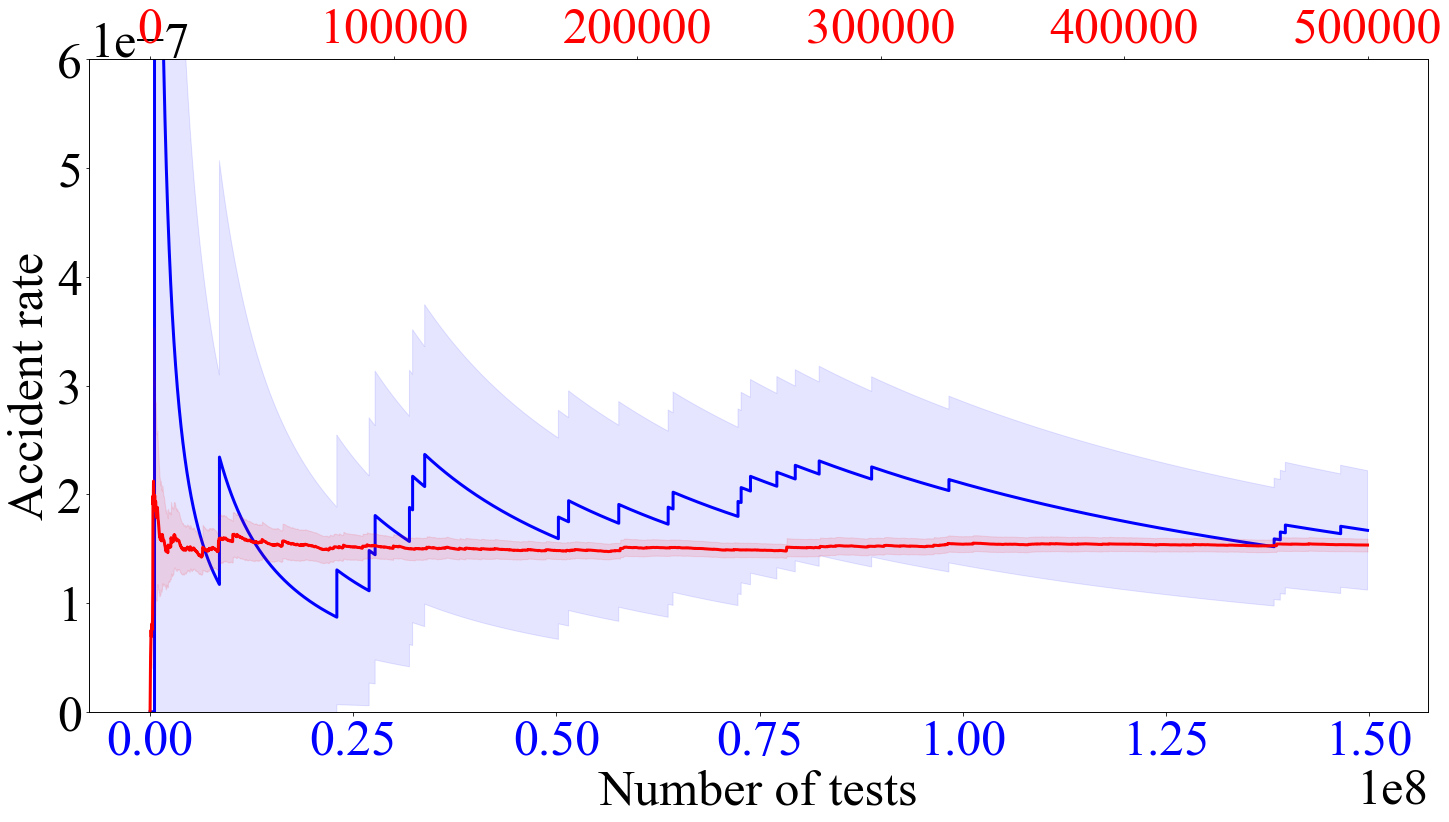

In [11]:
# Plot Accident rate
plot_interval = 100
plt.rcParams["font.family"] = "Times New Roman"
mpl.rcParams['font.size'] = 50
lw = 3
fig, ax2 = plt.subplots(figsize=(24,12))
save_flag = True
save_folder = os.path.join(r"./result", experiment_name)

# Plot NDE results
ax2.plot(NDE_crash_rate['Number_of_test'][1:], NDE_crash_rate['Accident_rate'][1:], 
         c="blue", label="NDE Evaluation", linewidth=lw)        
ax2.fill_between(NDE_crash_rate['Number_of_test'][1:], NDE_crash_rate['Confidence_interval_low'][1:],
                 NDE_crash_rate['Confidence_interval_high'][1:], color='b', alpha=.1)        
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel("Number of tests")
plt.ylabel("Accident rate")
for tl in ax2.get_xticklabels():
    tl.set_color('blue')    
print("NDE Accident rate (crash/sim):", NDE_crash_rate['Accident_rate'].iloc[-1])   

# Plot NADE results
ax1 = ax2.twiny() # ax1 and ax2 share y-axis
ax1.plot(range(Acc_raw_data_df.shape[0])[::plot_interval], Acc_raw_data_df["Acc_rate_all"][::plot_interval], 
         c="r", label="Proposed Method", linewidth=lw) 
ax1.fill_between(range(Acc_raw_data_df.shape[0])[::plot_interval], (Acc_raw_data_df["Acc_rate_all"][::plot_interval]-Acc_raw_data_df["half_CI"][::plot_interval]),
            (Acc_raw_data_df["Acc_rate_all"][::plot_interval]+Acc_raw_data_df["half_CI"][::plot_interval]), color='r', alpha=.1)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.get_yaxis().get_offset_text().set_position((-0.1,0))    
plt.ylabel("Accident Rate")
plt.ylim((0,6e-7))
    
for tl in ax1.get_xticklabels():
    tl.set_color('r')
print("NADE Accident rate (crash/sim):", Acc_raw_data_df["Acc_rate_all"].iloc[-1])
print("NADE Accident rate (mile/crash):", Acc_raw_data_df["Acc_rate_all_mile"].iloc[-1])
    

if save_flag:
    os.makedirs(save_folder, exist_ok=True)
    plt.savefig(os.path.join(save_folder, "Accident_rate.png"), bbox_inches="tight", dpi=300)
    

NDE coverge num: 140719440
NDE Accident rate (crash/sim):  1.6688639931318635e-07
NADE coverge num: 4862
NADE Accident rate (crash/sim): 1.534525352360234e-07


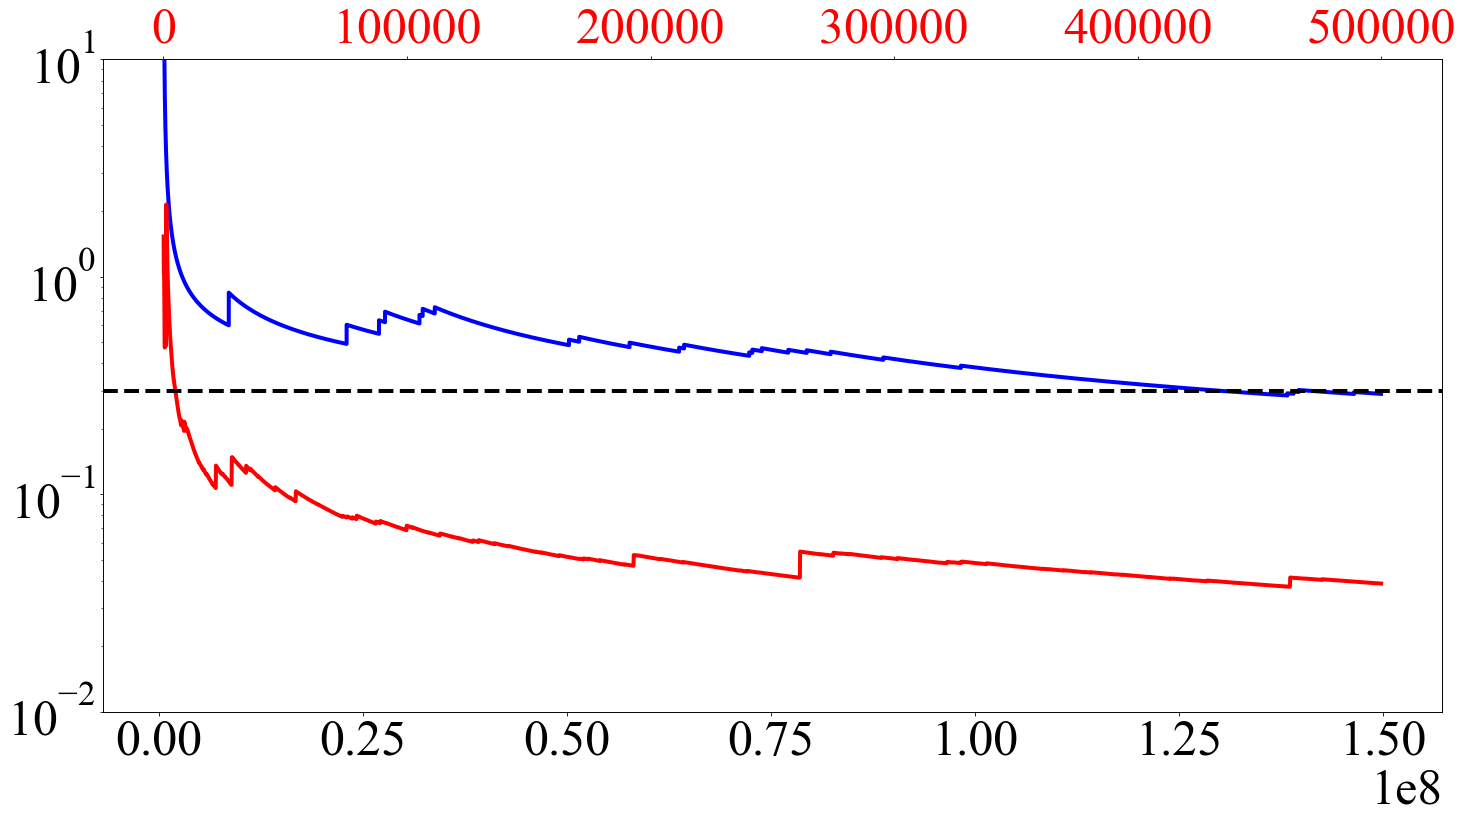

In [12]:
# Plot Relative half-width
plot_interval = 100
plt.rcParams["font.family"] = "Times New Roman"
mpl.rcParams['font.size'] = 50
save_flag = True
save_folder = os.path.join(r"./result", experiment_name)

fig, ax2 = plt.subplots(figsize=(24,12))
relative_halfwidth = 0.3
lw = 4

# Plot NDE result
ax2.plot(NDE_relative_half_width['Number_of_test'][1:], NDE_relative_half_width['Relative_half_width'][1:], 
         c="blue", label="NDE Evaluation", linewidth=lw)
print("NDE coverge num: 140719440")
print("NDE Accident rate (crash/sim): ", NDE_crash_rate['Accident_rate'].iloc[-1])  
    
# Plot NADE result
ax1 = ax2.twiny() # ax1 and ax2 share y-axis
ax1.plot(range(Acc_raw_data_df.shape[0])[::plot_interval], Acc_raw_data_df["Relative_halfwidth"][::plot_interval], 
    c="r", label="Proposed Method", linewidth=lw)
candidate = Acc_raw_data_df[(relative_halfwidth - Acc_raw_data_df["Relative_halfwidth"] < 1e-3) & (Acc_raw_data_df["Relative_halfwidth"] < relative_halfwidth)]
Acc_test_num = None
for idx in candidate.index:
    tmp = Acc_raw_data_df.iloc[idx:].dropna()
    if (tmp.Relative_halfwidth < relative_halfwidth).all():
        Acc_test_num = idx
        break
if Acc_test_num: 
    print("NADE coverge num:", Acc_test_num)       
plt.ylabel("Relative Half-width")
ax1.axes.set_yscale("log")   
ax1.axes.axhline(y=relative_halfwidth, c="k", linestyle="--", linewidth=lw)    
for tl in ax1.get_xticklabels():
    tl.set_color('r')
print("NADE Accident rate (crash/sim):", Acc_raw_data_df["Acc_rate_all"].iloc[-1])
plt.ylim((1e-2,1e1))

if save_flag:
    os.makedirs(save_folder, exist_ok=True)
    plt.savefig(os.path.join(save_folder, "Relative_half_width.png"), bbox_inches="tight", dpi=300)
